# COMPAS Recidivism


In this notebook we explore the COMPAS dataset for bias.

In [1]:
import pandas as pd
import fairlens as fl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## Preprocessing

We do the same preprocessing as ProPublica, dropping rows which are not usable. For more detail see 
[ProPublica's Analysis](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb).

In [2]:
df = df[(df["days_b_screening_arrest"] <= 30)
            & (df["days_b_screening_arrest"] >= -30)
            & (df["is_recid"] != -1)
            & (df["c_charge_degree"] != 'O')
            & (df["score_text"] != 'N/A')].reset_index()

df

,index,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
6168,7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
6169,7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
6170,7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## Analysis

Let's start by identifying the legally protected attributes we need to be aware of.

In [3]:
sensitive_attributes = fl.sensitive.detect_names_df(df, deep_search=True)
print(sensitive_attributes)
print(sensitive_attributes.keys())

{'sex': 'Gender', 'dob': 'Age', 'age': 'Age', 'race': 'Ethnicity'}
dict_keys(['sex', 'dob', 'age', 'race'])


We can inspect potential biases in decile scores by visualizing the distributions of different sensitive
sub-groups in the data.

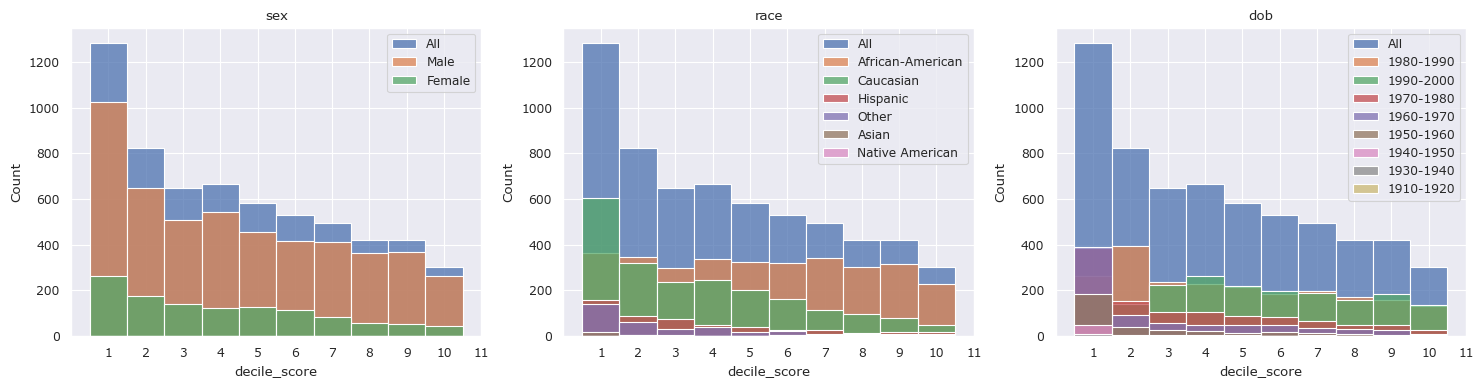

In [4]:
target_attribute = "decile_score"

fl.plot.use_style()
fl.plot.mult_distr_plot(df, target_attribute, ["sex", "race", "dob"])
plt.show()

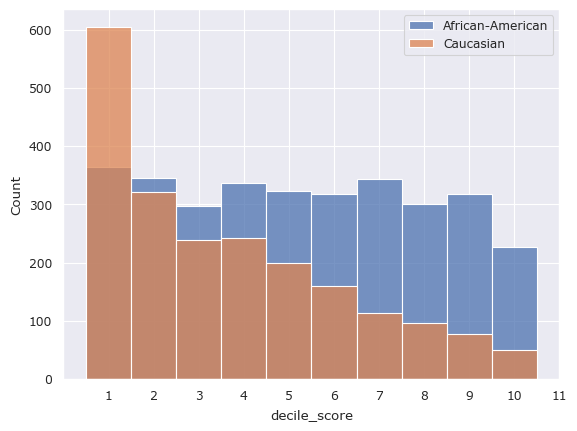

In [5]:
group1 = {"race": ["African-American"]}
group2 = {"race": ["Caucasian"]}

fl.plot.distr_plot(df, "decile_score", [group1, group2])
plt.legend(["African-American", "Caucasian"])
plt.show()

The above disparity can be quantified my measuring statistical distances between the two distributions.

In [6]:
from fairlens.metrics import stat_distance

distances = {}
for metric in ["emd", "norm", "hellinger"]:
    distances[metric] = stat_distance(df, "decile_score", group1, group2, mode=metric)


pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
emd,0.245107
norm,0.210866
hellinger,0.214566


## Training a Model

In [7]:
df_train = df[["sex", "race", "age_cat", "c_charge_degree", "priors_count", "two_year_recid", "score_text"]].copy()
df_train["sex"] = pd.factorize(df_train["sex"])[0]
df_train["race"] = pd.factorize(df_train["race"])[0]
df_train["age_cat"].replace(["Greater than 45", "25 - 45", "Less than 25"], [2, 1, 0], inplace=True)
df_train["c_charge_degree"] = pd.factorize(df_train["c_charge_degree"])[0]
df_train["score_text"] = pd.factorize(df_train["score_text"] != "Low")[0]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   sex              6172 non-null   int64
 1   race             6172 non-null   int64
 2   age_cat          6172 non-null   int64
 3   c_charge_degree  6172 non-null   int64
 4   priors_count     6172 non-null   int64
 5   two_year_recid   6172 non-null   int64
 6   score_text       6172 non-null   int64
dtypes: int64(7)
memory usage: 337.7 KB


/Users/aahil/Desktop/fairlens/venv/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


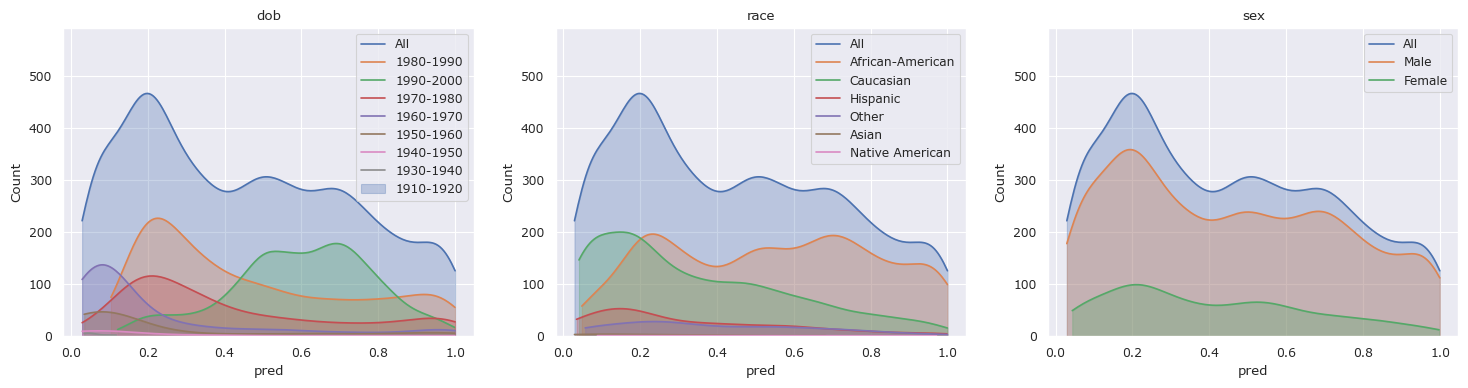

In [8]:
X = df_train[["sex", "race", "age_cat", "c_charge_degree", "priors_count", "two_year_recid"]].to_numpy()
y = df_train["score_text"].to_numpy()

clf = LogisticRegression(random_state=0).fit(X, y)
df["pred"] = clf.predict_proba(X)[:, 1]

fscorer = fl.FairnessScorer(df, "pred", ["race", "sex", "dob"])
fscorer.plot_distributions()
plt.show()